# 1. Data Preparing

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_table = pd.read_html(sp500_url)
sp500_df = sp500_table[0]
tickers = sp500_df['Symbol'].tolist()

end_date = '2024-09-30'
start_date = '2003-09-30'

def adj_close(tickers, start, end):
    # Download adjusted close prices
    data = yf.download(tickers=tickers, start=start, end=end, progress=True, group_by='ticker', auto_adjust=False, threads=True)
    if 'Adj Close' in data.columns:
        adj_close = data['Adj Close']
    else:
        adj_close = data.xs('Adj Close', level=1, axis=1)
    adj_close = adj_close.sort_index()

    return adj_close

def volume(tickers, start, end):
    # Download price and volume data (Note: volume is a separate column)
    data = yf.download(tickers=tickers, start=start, end=end, progress=True, group_by='ticker', auto_adjust=False, threads=True)

    # Extract volume data from the downloaded data
    if 'Volume' in data.columns:
        volume_data = data['Volume']
    else:
        # In case the data is multi-level (due to multiple tickers), we extract 'Volume' at the correct level
        volume_data = data.xs('Volume', level=1, axis=1)

    # Sort the data by date (index)
    volume_data = volume_data.sort_index()

    return volume_data
download = False
if download:
  sp500_close = adj_close(tickers, start=start_date, end=end_date)
  sp500_close = sp500_close.dropna(axis=1, how='all')
  sp500_close = sp500_close.fillna(method = 'ffill')

  sp500_volume = volume(tickers, start=start_date, end=end_date)
  sp500_volume = sp500_volume.dropna(axis=1, how='all')
  sp500_volume = sp500_volume.fillna(method = 'ffill')

del sp500_url

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
#sp500_close.to_pickle('sp500_close.pkl')
#sp500_volume.to_pickle('sp500_volume.pkl')
sp500_close = pd.read_pickle('sp500_full.pkl')
sp500_volume = pd.read_pickle('sp500_volume.pkl')
sp500_close.index=sp500_close.index.tz_localize(None)
sp500_volume.index = sp500_volume.index.tz_localize(None)

In [10]:
# Liquidity Metric
sp500_adtv = sp500_volume.rolling(window=63).mean() * sp500_close.rolling(window=63).mean()


In [11]:
# Sample Liquidity filter: Apply a minimum average volume threshold
min_avg_volume = 50000000  # Example threshold: stocks with an average daily volume above some number
liquid_stocks = sp500_adtv >= min_avg_volume

# Keep only the stocks with sufficient liquidity (i.e., where liquidity filter is True)
liquid_tickers = liquid_stocks.columns[liquid_stocks.iloc[-1]].tolist()

# Filter the adjusted close prices and volume for liquid stocks only
SP500_adj_close_filtered = sp500_close[liquid_tickers]
SP500_volume_filtered = sp500_volume[liquid_tickers]

# Now SP500_adj_close_filtered and SP500_volume_filtered contain only the stocks with sufficient liquidity
print(f'Number of liquid stocks: {len(liquid_tickers)}')

del min_avg_volume

Number of liquid stocks: 491


In [12]:
sp500_close.index=sp500_close.index.tz_localize(None)
liquid_stocks.index = liquid_stocks.index.tz_localize(None)
sp500_volume.index = sp500_volume.index.tz_localize(None)

In [77]:
names = ['TIE','BDK','CFC','BSC','CBE','ACS','MEE','BOL']
#drop columns with colnames in list
sp500_close = sp500_close.drop(columns=names)
sp500_close

KeyError: "['TIE', 'BDK', 'CFC', 'BSC', 'CBE', 'ACS', 'MEE', 'BOL'] not found in axis"

In [78]:
#compute vwap of price
vwap = (sp500_close*sp500_volume).cumsum()/sp500_volume.cumsum()
vwap_return = vwap.pct_change()
vwap

<ipython-input-78-751d2a31e185>:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  vwap_return = vwap.pct_change()


Ticker,A,AAL,AAP,AAPL,ABBV,ABNB,ABS,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2003-09-30,13.346772,NaN,NaN,0.312113,NaN,NaN,NaN,10.848971,NaN,NaN,...,6.916595,18.268635,NaN,NaN,NaN,7.322248,48.062458,NaN,NaN,NaN
2003-10-01,13.399125,NaN,NaN,0.312590,NaN,NaN,NaN,10.878510,NaN,NaN,...,6.923047,18.468216,NaN,NaN,NaN,7.604775,48.268537,NaN,NaN,NaN
2003-10-02,13.351084,NaN,NaN,0.311820,NaN,NaN,NaN,10.918338,NaN,NaN,...,6.958386,18.541267,NaN,NaN,NaN,7.646166,48.439308,NaN,NaN,NaN
2003-10-03,13.551443,NaN,NaN,0.316175,NaN,NaN,NaN,10.906783,NaN,NaN,...,6.977026,18.616397,NaN,NaN,NaN,7.654638,48.741067,NaN,NaN,NaN
2003-10-06,13.582576,NaN,NaN,0.320238,NaN,NaN,NaN,10.905530,NaN,NaN,...,6.986871,18.670514,NaN,NaN,NaN,7.661697,49.145790,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-23,39.329279,NaN,NaN,15.470082,72.093950,29.089851,NaN,34.461559,5.963727,81.489332,...,32.715250,51.450410,NaN,NaN,63.092068,40.109916,81.330934,65.763548,NaN,82.577289
2024-09-24,39.340733,NaN,NaN,15.474517,72.117421,29.162812,NaN,34.469352,5.973677,81.536495,...,32.725657,51.458112,NaN,NaN,63.117600,40.122277,81.335196,65.794049,NaN,82.604679
2024-09-25,39.349059,NaN,NaN,15.478805,72.147442,29.202711,NaN,34.477270,5.983251,81.594822,...,32.731796,51.466677,NaN,NaN,63.135806,40.128627,81.339062,65.821546,NaN,82.629702


# 2. Functions


In [79]:
#sperate the data into training set and validation set
train_data = sp500_close

daily_return = train_data.pct_change()
liquidity_screening = False
if liquidity_screening:
    daily_return = daily_return.where(liquid_stocks)
train_file_path = 'sp500_train.csv'
train_data.to_csv(train_file_path, index=False)


<ipython-input-79-ad5f45c0c439>:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_return = train_data.pct_change()


In [80]:
#momentum strategy timing(we try scale by volatility and exit by volatility of factor return/)
ff_momentum=pd.read_csv('F-F_Momentum_Factor_daily.CSV', header=11)
ff_momentum.columns = ['Date', 'Mom']
ff_momentum = ff_momentum[ff_momentum['Date'].astype(str).str.match(r'^\d{8}$')]
ff_momentum['Date'] = pd.to_datetime(ff_momentum['Date'])

ff_momentum.dropna(subset=['Mom'], inplace=True)
ff_momentum=ff_momentum.set_index('Date')
ff_momentum

,Mom
Date,
1926-11-03,0.56
1926-11-04,-0.50
1926-11-05,1.17
1926-11-06,-0.03
1926-11-08,-0.01
...,...
2024-09-24,0.03
2024-09-25,1.00
2024-09-26,-0.65


In [ ]:
def calculate_momentum_factor(df,length_months=11, skip_months=1,vol_window = 1,is_daily=False,sizing = False):
    if is_daily:
      momentum_factor = df.pct_change(periods=length_months*21).shift(skip_months*21)
    else:
      # Resample daily data to monthly using the last available price in each month
      monthly_prices = df.resample('M').last()
      # Calculate returns for the lookback period, skipping the most recent months
      momentum_factor = monthly_prices.pct_change(periods=length_months).shift(skip_months)
    if sizing:
      daily_returns = df.pct_change()

      # Calculate volatility over the specified lookback period (rolling standard deviation)
      volatility = daily_returns.rolling(window=vol_window*21).std()

      # Resample volatility to match monthly frequency (take the last value of each month)
      monthly_volatility = volatility.resample('M').last()

      # Standardize momentum and volatility separately (z-score normalization)
      standardized_momentum = momentum_factor.apply(
          lambda row: (row - row.mean()) / row.std() if row.std() != 0 else row * 0,
          axis=1
      )
      standardized_volatility = monthly_volatility.apply(
          lambda row: (row - row.mean()) / row.std() if row.std() != 0 else row * 0,
          axis=1
      )

      # Combine: Divide standardized momentum by standardized volatility
      momentum_factor = standardized_momentum / standardized_volatility
    # Calculate z-score for each row
    momentum_zscore = momentum_factor.apply(
        lambda row: (row - row.mean()) / row.std() if row.std() != 0 else row * 0,
        axis=1
    )

    return momentum_zscore

In [ ]:
def construct_momentum_strategy(momentum_factors, future_returns,long_threshold = 0.8,short_threshold = 0.2, rank_weight = False, ff_adjust = False,ff_momentum = ff_momentum):
    if ff_adjust:
      ff_momentum.index = pd.to_datetime(ff_momentum.index).normalize()
      # Calculate 126-day rolling volatility of FF momentum (daily data)
      ff_volatility = ff_momentum.rolling(window=126).std()
      # Resample volatility to monthly frequency using the last value of each month
      ff_volatility_monthly = ff_volatility.resample('M').last()

    # Initialize a DataFrame to store strategy returns
    strategy_returns = pd.DataFrame(index=momentum_factors.index, columns=["Strategy_Return"])

    positions = pd.DataFrame(index=momentum_factors.index, columns=["Long_Positions", "Short_Positions"])
    # Iterate over each month to calculate strategy returns
    for date, row in momentum_factors.iterrows():
        # Drop NA values to avoid errors
        row = row.dropna()

        # Identify long and short positions based on quantiles
        long_positions = row[row >= row.quantile(long_threshold)].index
        short_positions = row[row <= row.quantile(short_threshold)].index
        # Store positions in the positions DataFrame
        positions.at[date, "Long_Positions"] = long_positions
        positions.at[date, "Short_Positions"] = short_positions

        future_row = future_returns.loc[date]
        if rank_weight:
            # Get the momentum factors for long and short positions
          long_factors = row[long_positions]
          short_factors = row[short_positions]

          # Rank the long positions in descending order (higher momentum factors are better)
          long_ranks = long_factors.rank(method='first', ascending=False)
          if not long_ranks.empty:
              # Convert ranks to weights by dividing by the sum of ranks
              long_weights = long_ranks / long_ranks.sum()
          else:
              long_weights = pd.Series(dtype=float)

          # Rank the short positions in ascending order (lower momentum factors are better)
          short_ranks = short_factors.rank(method='first', ascending=True)
          if not short_ranks.empty:
              # Convert ranks to weights by dividing by the sum of ranks
              short_weights = short_ranks / short_ranks.sum()
          else:
              short_weights = pd.Series(dtype=float)

           # Calculate weighted returns for long positions
          long_return = (future_row[long_positions] * long_weights).sum() if not long_weights.empty else 0

          # Calculate weighted returns for short positions
          short_return = (future_row[short_positions] * short_weights).sum() if not short_weights.empty else 0
        else:
          long_return = future_row[long_positions].mean() if len(long_positions) > 0 else 0
          short_return = future_row[short_positions].mean() if len(short_positions) > 0 else 0

        # Calculate strategy return (long - short)
        if ff_adjust:
          adjustment_factor = 1 / ff_volatility_monthly.loc[date]['Mom']
          strategy_returns.loc[date, "Strategy_Return"] = (long_return - short_return)*adjustment_factor
        else:
          strategy_returns.loc[date, "Strategy_Return"] = long_return - short_return

    return strategy_returns,positions

In [ ]:
def vol_adjust(daily_return, positions, strategy_returns, scaled_factor = 1, target_vol = None):
  monthly_dates = positions.index
  forecasted_vol = pd.Series(index=monthly_dates, dtype='float64')
  for t in range(1, len(monthly_dates)):
      end_date = monthly_dates[t - 1]
      # find past 6 month
      start_date = end_date - pd.DateOffset(months=6)
      past_six_months_mask = (daily_return.index > start_date) & (daily_return.index <= end_date)
      past_six_months_dates = daily_return.loc[past_six_months_mask].index

      # calculated squared return
      squared_returns = daily_return.loc[past_six_months_dates,'Strategy_Return'] ** 2
      variance_forecast = 21 * squared_returns[-126:,].sum() / 126
      forecasted_vol.loc[monthly_dates[t]] = np.sqrt(variance_forecast)
  # print(forecasted_vol)
  if target_vol is None:
    target_monthly_vol = forecasted_vol.mean()
  else:
    target_monthly_vol = target_vol/np.sqrt(12)

  scaling = (target_monthly_vol/forecasted_vol)**(scaled_factor)
  scaling.replace([np.inf, -np.inf], 0, inplace=True)
  scaling[scaling < 0.2] = 0
  scaling[scaling > 3] = 3
  scaling.dropna(inplace=True)
  strategy_returns = strategy_returns['Strategy_Return']*scaling

  return strategy_returns,scaling

# 3. strategies - factor construction


In [113]:
#original momentum
future_returns = train_data.resample('M').last().pct_change(periods=1).shift(-1)
monthly_returns = (daily_return + 1).resample('M').prod() - 1
momentum_12m = calculate_momentum_factor(train_data, length_months=11, skip_months=1)
momentum_12m_daily = calculate_momentum_factor(train_data, length_months=11, skip_months=1,is_daily=True)
returns1,positions1 = construct_momentum_strategy(momentum_12m,future_returns)
cumret1 = (1 + returns1).cumprod()
cumret1.dropna().iloc[-1]

<ipython-input-113-7147b364813e>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_returns = train_data.resample('M').last().pct_change(periods=1).shift(-1)
<ipython-input-113-7147b364813e>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  future_returns = train_data.resample('M').last().pct_change(periods=1).shift(-1)
<ipython-input-113-7147b364813e>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = (daily_return + 1).resample('M').prod() - 1
<ipython-input-82-1b51e28dfd66>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = df.resample('M').last()
<ipython-input-82-1b51e28dfd66>:20: Futu

,2024-08-31
Strategy_Return,0.537033


In [114]:
#6month momentum
momentum_6m = calculate_momentum_factor(train_data, length_months=5, skip_months=1)
momentum_6m_daily = calculate_momentum_factor(train_data, length_months=5, skip_months=1,is_daily=True)
returns2,positions2 = construct_momentum_strategy(momentum_6m,future_returns)
cumret2 = (1 + returns2).cumprod()
cumret2.dropna().iloc[-1]

<ipython-input-82-1b51e28dfd66>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = df.resample('M').last()
<ipython-input-82-1b51e28dfd66>:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_factor = monthly_prices.pct_change(periods=length_months).shift(skip_months)
<ipython-input-82-1b51e28dfd66>:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_factor = df.pct_change(periods=length_months*21).shift(skip_months*21)


,2024-08-31
Strategy_Return,0.586744


In [115]:
#vwap momentum
momentum_vwap = calculate_momentum_factor(vwap, length_months=11, skip_months=1)
momentum_vwap_daily = calculate_momentum_factor(vwap, length_months=11, skip_months=1,is_daily=True)
returns3,positions3 = construct_momentum_strategy(momentum_vwap,future_returns)
cumret3 = (1 + returns3).cumprod()
cumret3.dropna().iloc[-1]

<ipython-input-82-1b51e28dfd66>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = df.resample('M').last()
<ipython-input-82-1b51e28dfd66>:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_factor = monthly_prices.pct_change(periods=length_months).shift(skip_months)
<ipython-input-82-1b51e28dfd66>:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_factor = df.pct_change(periods=length_months*21).shift(skip_months*21)


,2024-08-31
Strategy_Return,0.50558


In [116]:
#Vol-adj enhanced momentum(12m)

momentum_enhanced = calculate_momentum_factor(train_data, length_months=11, skip_months=1,sizing=True)
momentum_enhanced_daily = calculate_momentum_factor(train_data, length_months=11, skip_months=1,is_daily=True)
returns4,positions4 = construct_momentum_strategy(momentum_enhanced,future_returns)
cumret4 = (1 + returns4).cumprod()
cumret4.dropna().iloc[-1]

<ipython-input-82-1b51e28dfd66>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = df.resample('M').last()
<ipython-input-82-1b51e28dfd66>:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_factor = monthly_prices.pct_change(periods=length_months).shift(skip_months)
<ipython-input-82-1b51e28dfd66>:23: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = df.pct_change()
<ipython-input-82-1b51e28dfd66>:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
 

,2024-08-31
Strategy_Return,1.245477


In [117]:
#Vol- adj enhanced momentum(6m)
momentum_combined = calculate_momentum_factor(train_data, length_months=5, skip_months=1,sizing=True)
momentum_combined_daily = calculate_momentum_factor(train_data, length_months=5, skip_months=1,is_daily=True)
returns5,positions5 = construct_momentum_strategy(momentum_combined,future_returns)
cumret5 = (1 + returns5).cumprod()
cumret5.dropna().iloc[-1]


<ipython-input-82-1b51e28dfd66>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = df.resample('M').last()
<ipython-input-82-1b51e28dfd66>:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_factor = monthly_prices.pct_change(periods=length_months).shift(skip_months)
<ipython-input-82-1b51e28dfd66>:23: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = df.pct_change()
<ipython-input-82-1b51e28dfd66>:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
 

,2024-08-31
Strategy_Return,1.12445


# 4. vol adjust


In [118]:
# # targeted vol adj

# #unshifted return
return_daily = train_data.pct_change()
fac_ret_daily1,_ = construct_momentum_strategy(momentum_12m_daily,return_daily)
# returns1_adj,scaling1 = vol_adjust(fac_ret_daily1, positions1, returns1, target_vol = 0.12)
# cumret1 = (1 + returns1_adj).cumprod()
# cumret1.dropna().iloc[-1]

<ipython-input-118-c4299302216f>:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_daily = train_data.pct_change()


In [119]:
# ff_scale
returns2_adj,_ = construct_momentum_strategy(momentum_12m,future_returns,ff_adjust=True)
cumret2 = (1 + returns2_adj).cumprod()
cumret2.dropna().iloc[-1]

<ipython-input-83-3a7cfb2a1aaf>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ff_volatility_monthly = ff_volatility.resample('M').last()


,2024-08-31
Strategy_Return,2.105166


In [120]:
# scale factor 1 (Original 12m)
fac_ret_daily3,_ = construct_momentum_strategy(momentum_12m_daily,return_daily)
returns3_adj,scaling3 = vol_adjust(fac_ret_daily3, positions1, returns1, scaled_factor=1,target_vol=0.12)
cumret3 = (1 + returns3_adj).cumprod()
cumret3.dropna().iloc[-1]

2.205789255656112

In [121]:
# scale factor 2 (Original 12m)
fac_ret_daily4,_ = construct_momentum_strategy(momentum_12m_daily,return_daily)
returns4_adj,scaling4 = vol_adjust(fac_ret_daily4, positions1, returns1, scaled_factor=2)
cumret4 = (1 + returns4_adj).cumprod()
cumret4.dropna().iloc[-1]

6.6708910024342565

In [182]:
# enhanced(12m) + scaled 1.5
fac_ret_daily5,_ = construct_momentum_strategy(momentum_enhanced_daily,return_daily)
returns5_adj,scaling5 = vol_adjust(fac_ret_daily5, positions4, returns4, scaled_factor=2)
cumret5 = (1 + returns5_adj).cumprod()
cumret5.dropna().iloc[-1]

1.9562317641862401

In [123]:
# enhanced(6m) + scaled 1.5
fac_ret_daily6,_ = construct_momentum_strategy(momentum_combined_daily,return_daily)
returns6_adj,scaling6 = vol_adjust(fac_ret_daily6, positions5, returns5, scaled_factor=2)
cumret6 = (1 + returns6_adj).cumprod()
cumret6.dropna().iloc[-1]

1.668043389051033

In [124]:
# #sizing + 6m + ff
# returns5_adj,_ = construct_momentum_strategy(momentum_combined,future_returns,ff_adjust=True)
# cumret5 = (1 + returns5_adj).cumprod()
# cumret5.dropna().iloc[-1]


In [125]:
# #sizing + 6m + ff + scaled vol adj
# returns6_adj,scaling6 = vol_adjust(fac_ret_daily4, positions5, returns5_adj, scaled_factor=1)
# cumret6 = (1 + returns6_adj).cumprod()
# cumret6.dropna().iloc[-1]

# 5. Visualization

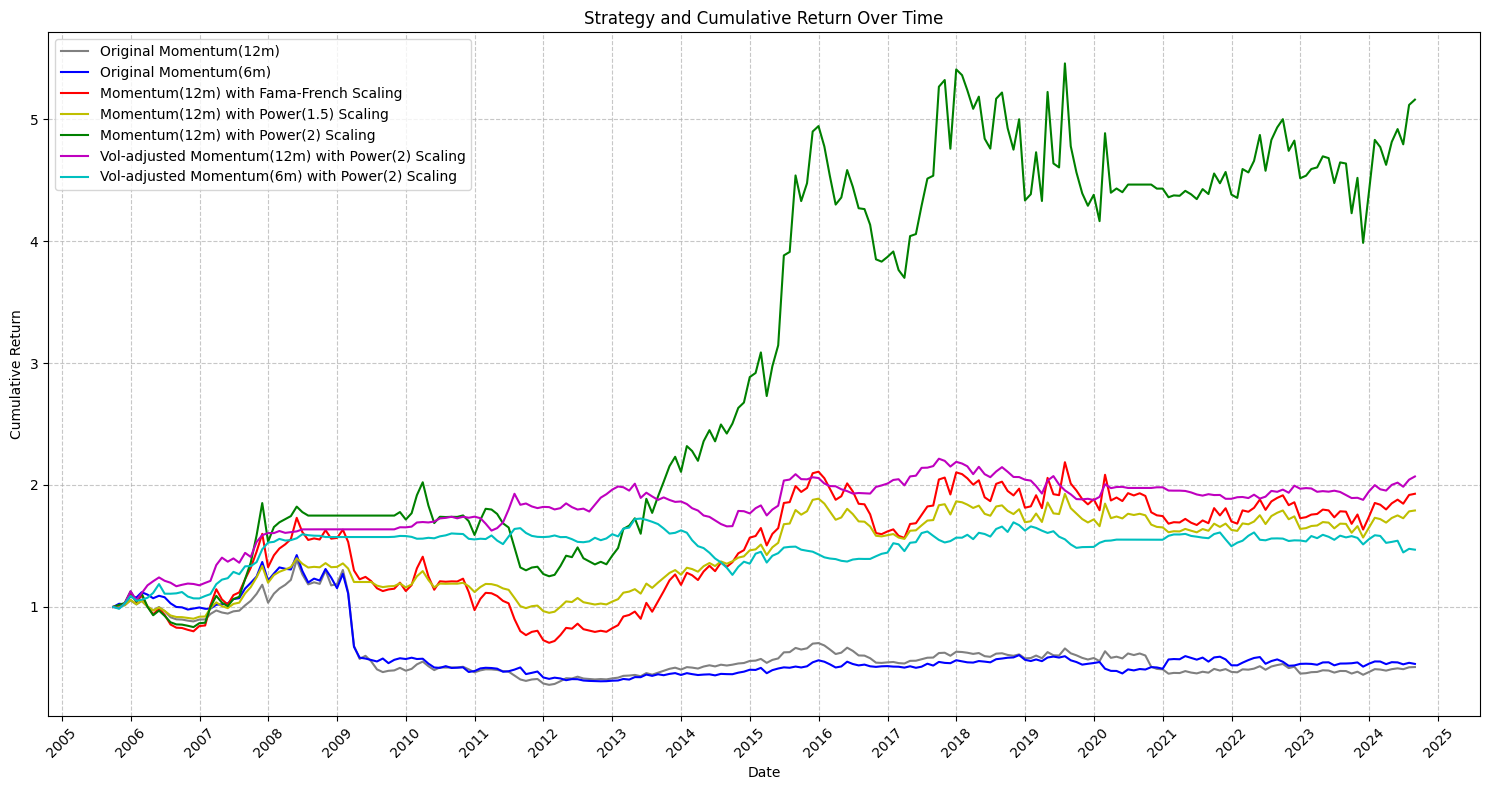

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

start_date = '2005-09-30'
end_date = '2024-09-30'

# Calculate cumulative returns and normalize the starting point to 1
s0 = (1 + returns1.loc[start_date:end_date,]).cumprod()
s1 = (1 + returns2.loc[start_date:end_date,]).cumprod()
s2 = (1 + returns2_adj.loc[start_date:end_date,]).cumprod()
s3 = (1 + returns3_adj.loc[start_date:end_date,]).cumprod()
s4 = (1 + returns4_adj.loc[start_date:end_date,]).cumprod()
s5 = (1 + returns5_adj.loc[start_date:end_date,]).cumprod()
s6 = (1 + returns6_adj.loc[start_date:end_date,]).cumprod()

s0 = s0 / s0.iloc[0]
s1 = s1 / s1.iloc[0]
s2 = s2 / s2.iloc[0]
s3 = s3 / s3.iloc[0]
s4 = s4 / s4.iloc[0]
s5 = s5 / s5.iloc[0]
s6 = s6 / s6.iloc[0]

# Plot the figure
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(s0, label='Original Momentum(12m)', color='grey')
ax.plot(s1, label='Original Momentum(6m)', color='b')
ax.plot(s2, label='Momentum(12m) with Fama-French Scaling ', color='r')
ax.plot(s3, label='Momentum(12m) with Power(1.5) Scaling', color='y')
ax.plot(s4, label='Momentum(12m) with Power(2) Scaling', color='g')
ax.plot(s5, label='Vol-adjusted Momentum(12m) with Power(2) Scaling', color='m')
ax.plot(s6, label='Vol-adjusted Momentum(6m) with Power(2) Scaling', color='c')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.set_title('Strategy and Cumulative Return Over Time')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


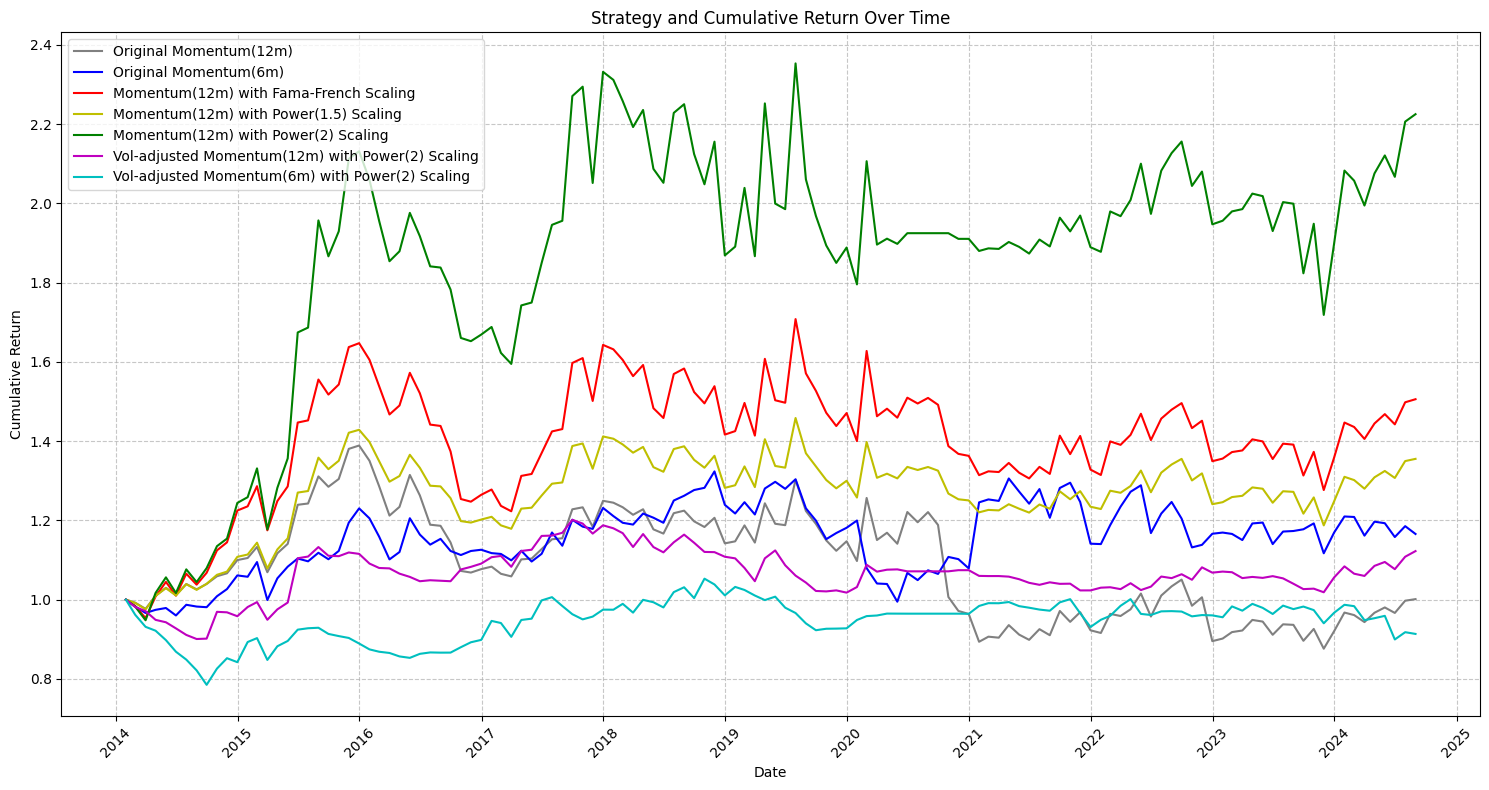

In [ ]:
start_date = '2014-01-01'
end_date = '2024-09-30'

s0 = (1+returns1.loc[start_date:end_date,]).cumprod()
s1 = (1+returns2.loc[start_date:end_date,]).cumprod()
s2 = (1+returns2_adj.loc[start_date:end_date,]).cumprod()
s3 = (1+returns3_adj.loc[start_date:end_date,]).cumprod()
s4 = (1+returns4_adj.loc[start_date:end_date,]).cumprod()
s5 = (1+returns5_adj.loc[start_date:end_date,]).cumprod()
s6 = (1+returns6_adj.loc[start_date:end_date,]).cumprod()

s0 = s0 / s0.iloc[0]
s1 = s1 / s1.iloc[0]
s2 = s2 / s2.iloc[0]
s3 = s3 / s3.iloc[0]
s4 = s4 / s4.iloc[0]
s5 = s5 / s5.iloc[0]
s6 = s6 / s6.iloc[0]

fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(s0, label='Original Momentum(12m)', color='grey')
ax.plot(s1, label='Original Momentum(6m)', color='b')
ax.plot(s2, label='Momentum(12m) with Fama-French Scaling ', color='r')
ax.plot(s3, label='Momentum(12m) with Power(1.5) Scaling', color='y')
ax.plot(s4, label='Momentum(12m) with Power(2) Scaling', color='g')
ax.plot(s5, label='Vol-adjusted Momentum(12m) with Power(2) Scaling', color='m')
ax.plot(s6, label='Vol-adjusted Momentum(6m) with Power(2) Scaling', color='c')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.set_title('Strategy and Cumulative Return Over Time')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [185]:
start_date = "2004-09-30"
start_date = pd.to_datetime(start_date)

screening_date = start_date + pd.DateOffset(years=1)
returns1 = returns1[returns1.index >= screening_date]
returns3_adj = returns3_adj[returns3_adj.index >= screening_date]
returns5_adj = returns5_adj[returns5_adj.index >= screening_date]

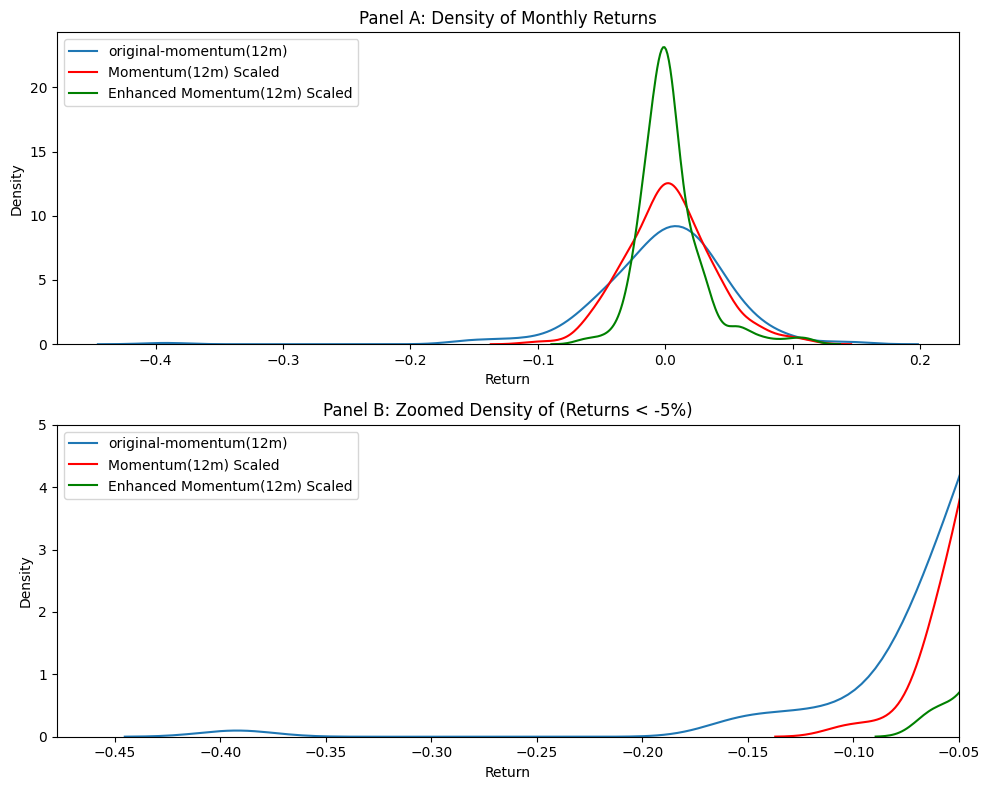

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.kdeplot(returns1, color='blue', label='original-momentum(12m)', linestyle='-', linewidth=1.5, fill=False)
sns.kdeplot(returns3_adj, color='r', label='Momentum(12m) Scaled', linestyle='-', linewidth=1.5, fill=False)
sns.kdeplot(returns5_adj, color='g', label='Enhanced Momentum(12m) Scaled', linestyle='-', linewidth=1.5, fill=False)
plt.xlabel('Return')
plt.ylabel('Density')
plt.title('Panel A: Density of Monthly Returns')
plt.legend()

plt.subplot(2, 1, 2)
sns.kdeplot(returns1, color='blue', label='original-momentum(12m)', linestyle='-', linewidth=1.5, fill=False)
sns.kdeplot(returns3_adj, color='r', label='Momentum(12m) Scaled', linestyle='-', linewidth=1.5, fill=False)
sns.kdeplot(returns5_adj, color='g', label='Enhanced Momentum(12m) Scaled', linestyle='-', linewidth=1.5, fill=False)
plt.xlabel('Return')
plt.ylabel('Density')
plt.title('Panel B: Zoomed Density of (Returns < -5%)')
plt.legend()
plt.xlim(None, -0.05) 
plt.ylim(0, 5)
plt.tight_layout()
plt.show()


# 6. Metrics

## 1. IC,IR,ICIR

In [187]:
def calculate_metrics(momentum_factors, future_returns,start_date=None, end_date=None):
    """
    Calculate IC, IR, and ICIR for the momentum factor by calculating row-wise correlations.

    Args:
        momentum_factors (pd.DataFrame): Momentum factor values for each stock (rows: dates, cols: stocks).
        future_returns (pd.DataFrame): Future returns for the next month for each stock (rows: dates, cols: stocks).

    Returns:
        dict: A dictionary containing IC, IR, and ICIR.
    """
    # Ensure both DataFrames are aligned
    aligned_momentum, aligned_future = momentum_factors.align(future_returns, join="inner", axis=0)

    # Calculate daily IC (row-wise correlation between stocks)
    ic_series = aligned_momentum.apply(lambda row: row.corr(aligned_future.loc[row.name]), axis=1)
    if start_date is not None and end_date is not None:
        ic_series = ic_series.loc[start_date:end_date]
    # Calculate IC metrics
    ic_mean = ic_series.mean()
    ic_std = ic_series.std()
    ic = ic_mean

    # Calculate IR (information ratio)
    ir = ic_mean / ic_std if ic_std != 0 else np.nan

    # Calculate ICIR
    icir = ir * np.sqrt(len(ic_series))

    return {"IC": ic, "IR": ir, "ICIR": icir, "IC Series": ic_series}

# Parameters
volatility_period=252
lookback_period =11  # e.g., 12 months
skip_period = 1       # e.g., exclude the most recent 1 month

# Calculate IC, IR, and ICIR
metrics1 = calculate_metrics(momentum_12m, future_returns)
metrics2 = calculate_metrics(momentum_6m, future_returns)
metrics3 = calculate_metrics(momentum_enhanced, future_returns)
metrics4 = calculate_metrics(momentum_combined, future_returns)

results = {
    "Momentum 12M": {"IC": metrics1["IC"], "IR": metrics1["IR"], "ICIR": metrics1["ICIR"]},
    "Momentum 6M": {"IC": metrics2["IC"], "IR": metrics2["IR"], "ICIR": metrics2["ICIR"]},
    "Momentum Enhanced(12M)": {"IC": metrics3["IC"], "IR": metrics3["IR"], "ICIR": metrics3["ICIR"]},
    "Momentum Enhanced(6M)": {"IC": metrics4["IC"], "IR": metrics4["IR"], "ICIR": metrics4["ICIR"]}
}

metrics_df = pd.DataFrame(results).transpose()

metrics_df


,IC,IR,ICIR
Momentum 12M,0.011466,0.063221,1.005590
Momentum 6M,0.007672,0.044262,0.704036
Momentum Enhanced(12M),-0.003099,-0.066695,-1.060855
Momentum Enhanced(6M),-0.003851,-0.088752,-1.411693


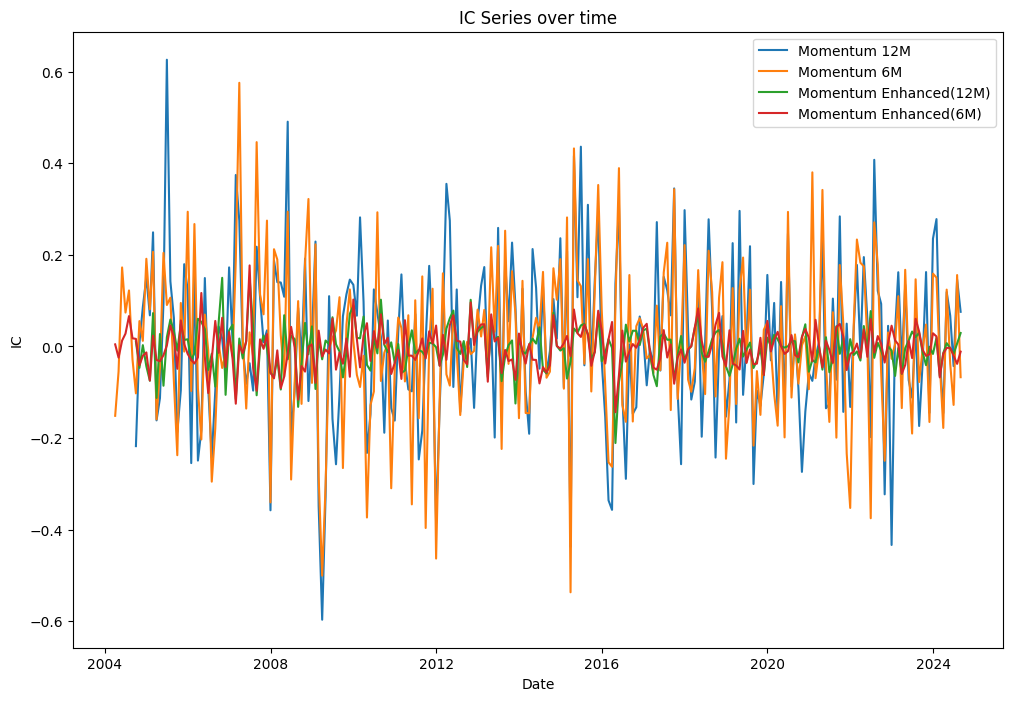

In [188]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(metrics1['IC Series'], label='Momentum 12M')
ax.plot(metrics2['IC Series'], label='Momentum 6M')
ax.plot(metrics3['IC Series'], label='Momentum Enhanced(12M)')
ax.plot(metrics4['IC Series'], label='Momentum Enhanced(6M)')

ax.set_xlabel('Date')
ax.set_ylabel('IC')
ax.set_title('IC Series over time')
ax.legend()



In [189]:
metrics1 = calculate_metrics(momentum_12m, future_returns,start_date='2019-01-01',end_date='2024-01-01')
metrics2 = calculate_metrics(momentum_6m, future_returns,start_date='2019-01-01',end_date='2024-01-01')
metrics3 = calculate_metrics(momentum_enhanced, future_returns,start_date='2019-01-01',end_date='2024-01-01')
metrics4 = calculate_metrics(momentum_combined, future_returns,start_date='2019-01-01',end_date='2024-01-01')

results = {
    "Momentum 12M": {"IC": metrics1["IC"], "IR": metrics1["IR"], "ICIR": metrics1["ICIR"]},
    "Momentum 6M": {"IC": metrics2["IC"], "IR": metrics2["IR"], "ICIR": metrics2["ICIR"]},
    "Momentum Enhanced(12M)": {"IC": metrics3["IC"], "IR": metrics3["IR"], "ICIR": metrics3["ICIR"]},
    "Momentum Enhanced(6M)": {"IC": metrics4["IC"], "IR": metrics4["IR"], "ICIR": metrics4["ICIR"]}
}

metrics_df = pd.DataFrame(results).transpose()

metrics_df

,IC,IR,ICIR
Momentum 12M,-0.002467,-0.014723,-0.114045
Momentum 6M,0.000303,0.001865,0.014444
Momentum Enhanced(12M),-0.007882,-0.256960,-1.990407
Momentum Enhanced(6M),-0.000788,-0.024006,-0.185950


## 2. Distribution, Sharpe Ratio, Returns, StDev

In [ ]:
from scipy.stats import kurtosis as kurtosis_func, skew as skew_func

def calculate_performance_metrics(return_series,start_date=None,end_date=None):
    """
    Calculate performance metrics for a given return series (monthly frequency).

    Args:
        return_series (pd.Series): Monthly returns of a strategy (index: dates, values: returns).

    Returns:
        dict: A dictionary containing Sharpe ratio, drawdown, volatility,
              annualized return, and other performance metrics.
    """
    # Ensure input is a Pandas Series
    if not isinstance(return_series, pd.Series):
        raise ValueError("Input must be a pandas Series.")

    if start_date is not None and end_date is not None:
        return_series = return_series.loc[start_date:end_date]
    # Drop NaN values for calculations

    return_series = return_series.dropna()
    return_series = pd.to_numeric(return_series, errors='coerce').dropna()
    # Calculate cumulative returns
    cumulative_returns = (1 + return_series).cumprod()

    # Annualized Return
    total_return = cumulative_returns.iloc[-1] / cumulative_returns.iloc[0] - 1
    num_years = len(return_series) / 12  # Convert months to years
    annualized_return = (1 + total_return) ** (1 / num_years) - 1

    # Annualized Volatility
    annualized_volatility = return_series.std() * np.sqrt(12)

    # Sharpe Ratio (assuming risk-free rate is 0)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

    # Drawdown calculation
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # Monthly return statistics
    mean_monthly_return = return_series.mean()
    std_monthly_return = return_series.std()
    kurtosis_value = kurtosis_func(return_series)  # Use the imported kurtosis function
    skew_value = skew_func(return_series)          # Use the imported skew function

    # Prepare output metrics
    metrics = {
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Mean Monthly Return": mean_monthly_return,
        "Monthly Volatility": std_monthly_return,
        "Skewness": skew_value,
        "Kurtosis": kurtosis_value
    }

    return metrics

perf_metrics1 = calculate_performance_metrics(returns1['Strategy_Return'])
perf_metrics2  = calculate_performance_metrics(returns2['Strategy_Return'])
perf_metrics3 = calculate_performance_metrics(returns2_adj['Strategy_Return'])
perf_metrics4 = calculate_performance_metrics(returns3_adj)
perf_metrics5 = calculate_performance_metrics(returns4_adj)
perf_metrics6 = calculate_performance_metrics(returns5_adj)
perf_metrics7 = calculate_performance_metrics(returns6_adj)
metrics_dicts = {
    'Original Momentum(12m)': perf_metrics1,
    "Original Momentum(6m)": perf_metrics2,
    "Momentum(12m) with Fama-French Scaling": perf_metrics3,
    "Momentum(12m) with Power(1.5) Scaling": perf_metrics4,
    "Momentum(12m) with Power(2) Scaling": perf_metrics5,
    "Vol-adjusted Momentum(12m) with Power(2) Scaling": perf_metrics6,
    "Vol-adjusted Momentum(6m) with Power(2) Scaling": perf_metrics7
}

perf_metrics_df = pd.DataFrame(metrics_dicts)

perf_metrics_df = perf_metrics_df.T

perf_metrics_df


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Mean Monthly Return,Monthly Volatility,Skewness,Kurtosis
Original Momentum(12m),-0.035101,0.181807,-0.193065,-0.739280,-0.001647,0.052483,-2.005040,12.996391
Original Momentum(6m),-0.025069,0.160505,-0.156191,-0.726047,-0.000922,0.046334,-2.567056,20.047919
Momentum(12m) with Fama-French Scaling,0.036083,0.196615,0.183522,-0.592090,0.004554,0.056758,0.143717,0.553241
Momentum(12m) with Power(1.5) Scaling,0.031144,0.117305,0.265495,-0.319786,0.002927,0.033863,0.216554,0.535644
Momentum(12m) with Power(2) Scaling,0.094972,0.214213,0.443356,-0.381128,0.009442,0.061838,0.607490,1.430967
Vol-adjusted Momentum(12m) with Power(2) Scaling,0.039027,0.083691,0.466322,-0.174011,0.003317,0.024160,1.417746,4.443344
Vol-adjusted Momentum(6m) with Power(2) Scaling,0.024763,0.077773,0.318401,-0.267768,0.002290,0.022451,0.442450,1.220786


In [ ]:
perf_metrics1 = calculate_performance_metrics(returns1['Strategy_Return'],start_date='2014-01-01',end_date='2024-09-30')
perf_metrics2  = calculate_performance_metrics(returns2['Strategy_Return'],start_date='2014-01-01',end_date='2024-09-30')
perf_metrics3 = calculate_performance_metrics(returns2_adj['Strategy_Return'],start_date='2014-01-01',end_date='2024-09-30')
perf_metrics4 = calculate_performance_metrics(returns3_adj,start_date='2014-01-01',end_date='2024-09-30')
perf_metrics5 = calculate_performance_metrics(returns4_adj,start_date='2014-01-01',end_date='2024-09-30')
perf_metrics6 = calculate_performance_metrics(returns5_adj,start_date='2014-01-01',end_date='2024-09-30')
perf_metrics7 = calculate_performance_metrics(returns6_adj,start_date='2014-01-01',end_date='2024-09-30')
metrics_dicts = {
    'Original Momentum(12m)': perf_metrics1,
    "Original Momentum(6m)": perf_metrics2,
    "Momentum(12m) with Fama-French Scaling": perf_metrics3,
    "Momentum(12m) with Power(1.5) Scaling": perf_metrics4,
    "Momentum(12m) with Power(2) Scaling": perf_metrics5,
    "Vol-adjusted Momentum(12m) with Power(2) Scaling": perf_metrics6,
    "Vol-adjusted Momentum(6m) with Power(2) Scaling": perf_metrics7
}

perf_metrics_df1 = pd.DataFrame(metrics_dicts)

perf_metrics_df1 = perf_metrics_df1.T

perf_metrics_df1

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Mean Monthly Return,Monthly Volatility,Skewness,Kurtosis
Original Momentum(12m),0.000131,0.144142,0.000906,-0.369140,0.001190,0.041610,-0.120823,1.578560
Original Momentum(6m),0.014485,0.126409,0.114587,-0.248383,0.002115,0.036491,0.123774,1.992088
Momentum(12m) with Fama-French Scaling,0.039125,0.168713,0.231905,-0.257524,0.004991,0.048703,0.538392,0.678051
Momentum(12m) with Power(1.5) Scaling,0.028915,0.115890,0.249506,-0.185780,0.003272,0.033454,0.541338,0.813573
Momentum(12m) with Power(2) Scaling,0.077868,0.222384,0.350151,-0.269696,0.008996,0.064197,0.746003,1.596221
Vol-adjusted Momentum(12m) with Power(2) Scaling,0.010902,0.071989,0.151438,-0.152973,0.001024,0.020782,1.782473,6.540916
Vol-adjusted Momentum(6m) with Power(2) Scaling,-0.008441,0.077045,-0.109558,-0.214891,-0.000555,0.022241,0.132784,0.560820


In [ ]:
perf_metrics1 = calculate_performance_metrics(returns1['Strategy_Return'],start_date='2003-09-30',end_date='2014-01-01')
perf_metrics2  = calculate_performance_metrics(returns2['Strategy_Return'],start_date='2003-09-30',end_date='2014-01-01')
perf_metrics3 = calculate_performance_metrics(returns2_adj['Strategy_Return'],start_date='2003-09-30',end_date='2014-01-01')
perf_metrics4 = calculate_performance_metrics(returns3_adj,start_date='2003-09-30',end_date='2014-01-01')
perf_metrics5 = calculate_performance_metrics(returns4_adj,start_date='2003-09-30',end_date='2014-01-01')
perf_metrics6 = calculate_performance_metrics(returns5_adj,start_date='2003-09-30',end_date='2014-01-01')
perf_metrics7 = calculate_performance_metrics(returns6_adj,start_date='2003-09-30',end_date='2014-01-01')
metrics_dicts = {
    'Original Momentum(12m)': perf_metrics1,
    "Original Momentum(6m)": perf_metrics2,
    "Momentum ff adj": perf_metrics3,
    "Momentum Scaled": perf_metrics4,
    "Momentum Scaled(2)": perf_metrics5,
    "Enhanced Momentum Scaled(12m)": perf_metrics6,
    "Enhanced Momentum Scaled(6m)": perf_metrics7
}

perf_metrics_df2 = pd.DataFrame(metrics_dicts)

perf_metrics_df2 = perf_metrics_df2.T

perf_metrics_df2

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Mean Monthly Return,Monthly Volatility,Skewness,Kurtosis
Original Momentum(12m),-0.082836,0.221025,-0.374780,-0.739280,-0.005278,0.063804,-2.424399,12.248824
Original Momentum(6m),-0.067247,0.189309,-0.355226,-0.726047,-0.004056,0.054649,-3.141600,19.618221
Momentum ff adj,0.024913,0.222467,0.111984,-0.592090,0.004104,0.064221,-0.030643,0.177625
Momentum Scaled,0.028542,0.119661,0.238528,-0.319786,0.002485,0.034543,-0.160105,0.180851
Momentum Scaled(2),0.102758,0.206263,0.498188,-0.381128,0.009907,0.059543,0.427730,1.154843
Enhanced Momentum Scaled(12m),0.077642,0.096052,0.808338,-0.075530,0.006252,0.027728,1.052760,2.796545
Enhanced Momentum Scaled(6m),0.061751,0.077509,0.796695,-0.099156,0.005250,0.022375,0.777299,1.633560


## 3. Turnover

In [ ]:
def compute_weights(row):
    weights = {}
    longs = row['Long_Positions']
    shorts = row['Short_Positions']

    if isinstance(longs, str):
        longs = [s.strip() for s in longs.split(',')]
    if isinstance(shorts, str):
        shorts = [s.strip() for s in shorts.split(',')]

    num_longs = len(longs)
    num_shorts = len(shorts)

    if num_longs > 0 and num_shorts > 0:
        total_weight = 1.0  
        long_weight = total_weight / (2 * num_longs)  
        short_weight = -total_weight / (2 * num_shorts)  

        for symbol in longs:
            weights[symbol] = long_weight
        for symbol in shorts:
            weights[symbol] = short_weight
    elif num_longs > 0:  
        long_weight = 1.0 / num_longs
        for symbol in longs:
            weights[symbol] = long_weight
    elif num_shorts > 0:  
        short_weight = -1.0 / num_shorts
        for symbol in shorts:
            weights[symbol] = short_weight

    return weights

weights_list = positions1.apply(compute_weights, axis=1)

weights_df = pd.DataFrame(weights_list.tolist(), index=positions1.index).fillna(0)

weights_df = weights_df.sort_index(axis=1)
weights_df = weights_df[weights_df.index > "2004-09-30"]

all_stocks = momentum_12m.columns

weights_df_aligned = weights_df.reindex(columns=all_stocks, fill_value=0)
weights_df_aligned = weights_df_aligned.reindex(index=momentum_12m.index).fillna(0)


w_prev = weights_df_aligned.shift(1)
weight_diff = (weights_df_aligned - w_prev).abs()
turnover_initial = 0.5 * weight_diff.sum(axis=1)
turnover_initial_df = turnover_initial.to_frame(name='Turnover_Initial')
w_scaled = weights_df.div(scaling3, axis=0)
w_scaled_prev = w_scaled.shift(1)

weight_diff_scaled = (w_scaled - w_scaled_prev).abs()
turnover_risk_managed = 0.5 * weight_diff_scaled.sum(axis=1)
turnover_risk_managed_df = turnover_risk_managed.to_frame(name='Turnover_Risk_Managed')

turnover_df = pd.concat([turnover_initial_df, turnover_risk_managed_df], axis=1).fillna(0)
turnover_df
turnover_df.mean(axis=0)

,0
Turnover_Initial,0.227323
Turnover_Risk_Managed,inf


In [ ]:
def calculate_turnover(
    positions_df: pd.DataFrame,
    compute_weights_func,
    momentum_df: pd.DataFrame,
    scaling_series: pd.Series,
    date_threshold: str = "2004-09-30"
) -> pd.DataFrame:

    # Compute weights for each position
    weights_list = positions_df.apply(compute_weights_func, axis=1)
    weights_df = pd.DataFrame(weights_list.tolist(), index=positions_df.index).fillna(0)

    # Sort the weights DataFrame columns and filter by date
    weights_df = weights_df.sort_index(axis=1)
    weights_df = weights_df[weights_df.index > date_threshold]

    # Align weights DataFrame with all stocks from momentum_df
    all_stocks = momentum_df.columns
    weights_df_aligned = weights_df.reindex(columns=all_stocks, fill_value=0)
    weights_df_aligned = weights_df_aligned.reindex(index=momentum_df.index).fillna(0)

    # Calculate initial turnover
    w_prev = weights_df_aligned.shift(1)
    weight_diff = (weights_df_aligned - w_prev).abs()
    turnover_initial = 0.5 * weight_diff.sum(axis=1)
    turnover_initial_df = turnover_initial.to_frame(name='Turnover_Before_Scaling')

    # Scale the weights and calculate risk-managed turnover

    w_scaled = weights_df_aligned.div(scaling_series, axis=0).where(scaling_series != 0, np.nan)

    w_scaled_prev = w_scaled.shift(1)
    weight_diff_scaled = (w_scaled - w_scaled_prev).abs()
    turnover_risk_managed = 0.5 * weight_diff_scaled.sum(axis=1)
    turnover_risk_managed_df = turnover_risk_managed.to_frame(name='Turnover_After_Scaling')

    # Combine both turnover metrics into a single DataFrame
    turnover_df = pd.concat([turnover_initial_df, turnover_risk_managed_df], axis=1).fillna(0)

    return turnover_df, turnover_df.mean()

positions_list = [positions1, positions2,positions4, positions5]
position_names = ['12m', '6m', 'Vol_adj 12m', 'Vol_adj 6m']

mean_turnover_list = []

for name, positions_df in zip(position_names, positions_list):
    turnover_results, mean_turnover = calculate_turnover(
        positions_df=positions_df,
        compute_weights_func=compute_weights,
        momentum_df=momentum_12m,
        scaling_series=scaling3,
        date_threshold="2004-09-30"  
    )

    mean_turnover = mean_turnover.rename(name)

    mean_turnover_list.append(mean_turnover)

summary_df = pd.concat(mean_turnover_list, axis=1).T  
summary_df = summary_df[['Turnover_Before_Scaling', 'Turnover_After_Scaling']]

print("Strategy Turnover：")
print(summary_df)

summary_df

Strategy Turnover：
             Turnover_Before_Scaling  Turnover_After_Scaling
12m                         0.227323                0.351660
6m                          0.339349                0.500940
Vol_adj 12m                 0.558102                0.794224
Vol_adj 6m                  0.585917                0.832431

LaTeX 表格：
\begin{tabular}{lrr}
\toprule
 & Turnover_Before_Scaling & Turnover_After_Scaling \\
\midrule
12m & 0.2273 & 0.3517 \\
6m & 0.3393 & 0.5009 \\
Vol_adj 12m & 0.5581 & 0.7942 \\
Vol_adj 6m & 0.5859 & 0.8324 \\
\bottomrule
\end{tabular}



,Turnover_Before_Scaling,Turnover_After_Scaling
12m,0.227323,0.351660
6m,0.339349,0.500940
Vol_adj 12m,0.558102,0.794224
Vol_adj 6m,0.585917,0.832431


## 4. AR(1)

In [ ]:
wml_daily_return = pd.Series(0, index=daily_return.index)

for i, position_date in enumerate(positions1.index):
    if i < len(positions1.index) - 1:
        next_position_date = positions1.index[i + 1]
    else:
        next_position_date = daily_return.index[-1]

    next_month_mask = (daily_return.index > position_date) & (daily_return.index <= next_position_date)
    next_month_dates = daily_return.loc[next_month_mask].index

    long_positions = positions1.loc[position_date, 'Long_Positions']
    short_positions = positions1.loc[position_date, 'Short_Positions']

    if len(long_positions) > 0:
        long_returns = daily_return.loc[next_month_dates, long_positions].mean(axis=1)
    else:
        long_returns = pd.Series(0, index=next_month_dates)

    if len(short_positions) > 0:
        short_returns = daily_return.loc[next_month_dates, short_positions].mean(axis=1)
    else:
        short_returns = pd.Series(0, index=next_month_dates)

    wml_daily_return.loc[next_month_dates] = long_returns - short_returns

wml_daily_return = wml_daily_return.to_frame(name='WML_Return')
wml_daily_return = wml_daily_return.squeeze()

<ipython-input-134-070418d41d2f>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.0135672  -0.00676547  0.00385097  0.00551257 -0.00235896  0.00931085
 -0.00299298  0.00127511 -0.02060878  0.0189543  -0.00087231 -0.00958744
 -0.00745826 -0.00502632 -0.00025219  0.0003876   0.01580334  0.00490296
 -0.01803899 -0.00775467  0.00516095]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wml_daily_return.loc[next_month_dates] = long_returns - short_returns


In [ ]:
def compute_wml_daily_return(positions: pd.DataFrame, daily_return: pd.DataFrame) -> pd.Series:
    # Initialize a Series to store daily WML (Winners minus Losers) returns
    wml_daily_return = pd.Series(0, index=daily_return.index)

    # Loop through each month-end date in the positions DataFrame
    for i, position_date in enumerate(positions.index):
        # Determine the range of trading days for the next month
        if i < len(positions.index) - 1:
            next_position_date = positions.index[i + 1]
        else:
            next_position_date = daily_return.index[-1]

        # Filter trading days between the current and next month-end
        next_month_mask = (daily_return.index > position_date) & (daily_return.index <= next_position_date)
        next_month_dates = daily_return.loc[next_month_mask].index

        # Get current long and short positions
        long_positions = positions.loc[position_date, 'Long_Positions']
        short_positions = positions.loc[position_date, 'Short_Positions']

        # Compute average return for long positions
        if isinstance(long_positions, (list, pd.Index, pd.Series)) and len(long_positions) > 0:
            long_returns = daily_return.loc[next_month_dates, long_positions].mean(axis=1)
        elif isinstance(long_positions, str) and long_positions:
            long_returns = daily_return.loc[next_month_dates, [long_positions]].mean(axis=1)
        else:
            long_returns = pd.Series(0, index=next_month_dates)

        # Compute average return for short positions
        if isinstance(short_positions, (list, pd.Index, pd.Series)) and len(short_positions) > 0:
            short_returns = daily_return.loc[next_month_dates, short_positions].mean(axis=1)
        elif isinstance(short_positions, str) and short_positions:
            short_returns = daily_return.loc[next_month_dates, [short_positions]].mean(axis=1)
        else:
            short_returns = pd.Series(0, index=next_month_dates)

        # Compute WML return (long - short)
        wml_daily_return.loc[next_month_dates] = long_returns - short_returns

    # Convert Series to DataFrame and then back to Series with named column
    wml_daily_return = wml_daily_return.to_frame(name='WML_Return').squeeze()

    return wml_daily_return

# Apply the function to multiple position sets
wml_daily_return1 = compute_wml_daily_return(positions1, daily_return)
wml_daily_return2 = compute_wml_daily_return(positions2, daily_return)
wml_daily_return3 = compute_wml_daily_return(positions3, daily_return)
wml_daily_return4 = compute_wml_daily_return(positions4, daily_return)
wml_daily_return5 = compute_wml_daily_return(positions5, daily_return)

<ipython-input-135-05fcda50c45d>:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.0135672  -0.00676547  0.00385097  0.00551257 -0.00235896  0.00931085
 -0.00299298  0.00127511 -0.02060878  0.0189543  -0.00087231 -0.00958744
 -0.00745826 -0.00502632 -0.00025219  0.0003876   0.01580334  0.00490296
 -0.01803899 -0.00775467  0.00516095]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wml_daily_return.loc[next_month_dates] = long_returns - short_returns
<ipython-input-135-05fcda50c45d>:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.61760258e-05  8.83573289e-03 -8.31152392e-03 -6.37267982e-03
  8.76619414e-03  3.59648390e-03  8.89017898e-03 -1.79317744e-02
 -4.94495303e-03 -8.42843586e-03  2.35403288e-03  6.68938377e-03
 -1.32720462e-02  1.02078215e-02  1.29847559e-03  8.5684

<ipython-input-136-03fa41e4d02f>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = squared_returns.resample('M').apply(lambda x: x.index[-1] if len(x) > 0 else np.nan).dropna()


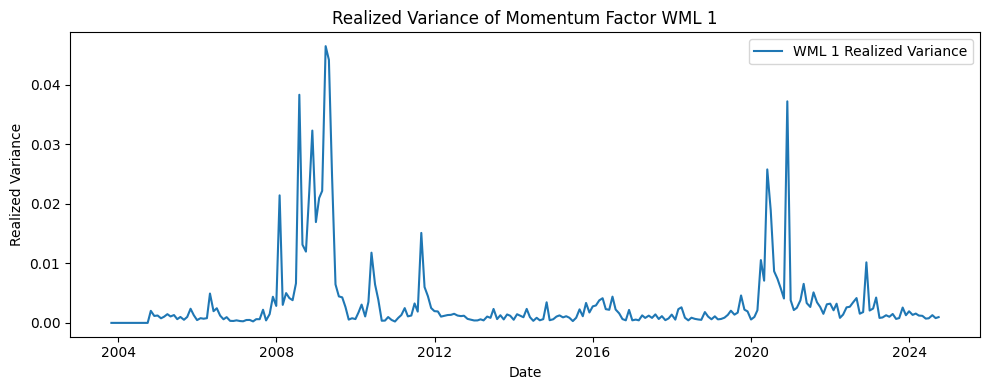

<ipython-input-136-03fa41e4d02f>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = squared_returns.resample('M').apply(lambda x: x.index[-1] if len(x) > 0 else np.nan).dropna()


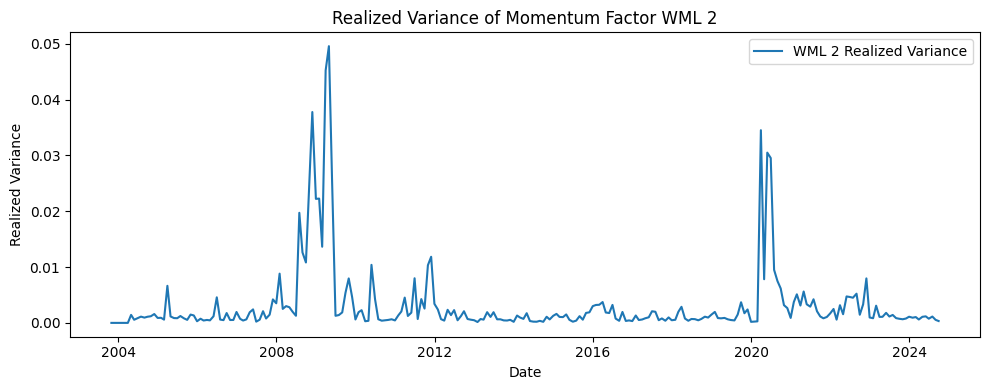

<ipython-input-136-03fa41e4d02f>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = squared_returns.resample('M').apply(lambda x: x.index[-1] if len(x) > 0 else np.nan).dropna()


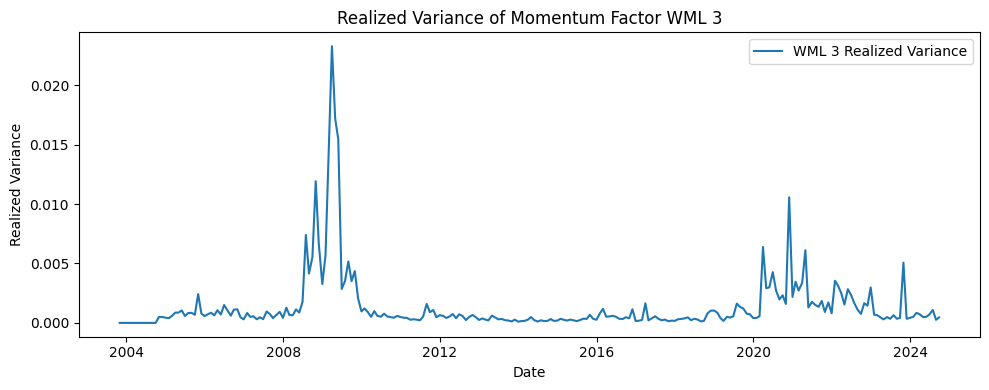

<ipython-input-136-03fa41e4d02f>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = squared_returns.resample('M').apply(lambda x: x.index[-1] if len(x) > 0 else np.nan).dropna()


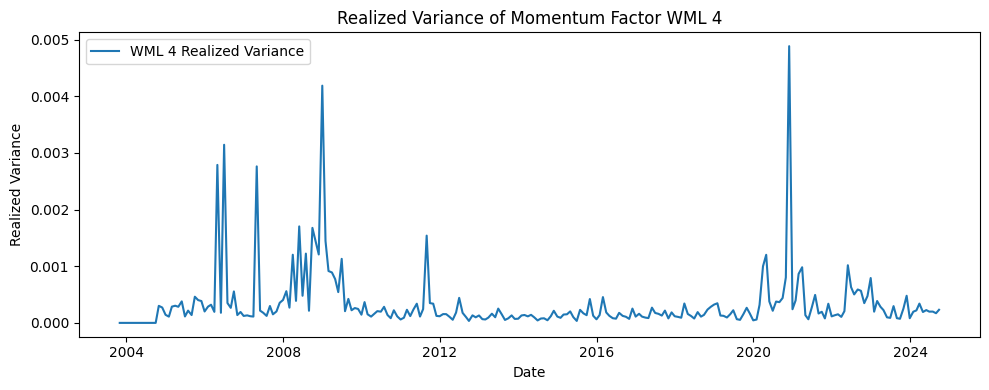

<ipython-input-136-03fa41e4d02f>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = squared_returns.resample('M').apply(lambda x: x.index[-1] if len(x) > 0 else np.nan).dropna()


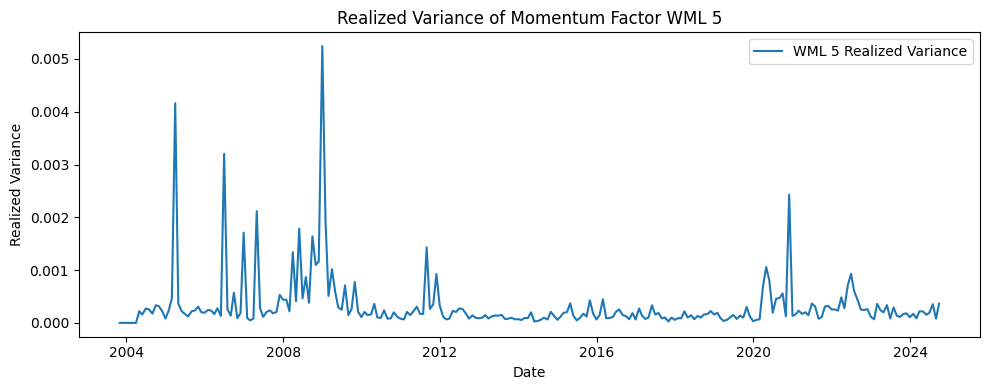


回归结果汇总：
  Portfolio       α  t-stat(α)     ρ  t-stat(ρ)     R²
0     WML 1  0.0012       3.27  0.65      13.65  42.80
1     WML 2  0.0010       2.93  0.69      14.97  47.36
2     WML 3  0.0003       2.70  0.76      18.30  57.35
3     WML 4  0.0003       6.37  0.24       3.88   5.71
4     WML 5  0.0002       6.18  0.24       3.98   5.99

LaTeX 表格：
\begin{tabular}{lrrrrr}
\toprule
Portfolio & α & t-stat(α) & ρ & t-stat(ρ) & R² \\
\midrule
WML 1 & 0.00 & 3.27 & 0.65 & 13.65 & 42.80 \\
WML 2 & 0.00 & 2.93 & 0.69 & 14.97 & 47.36 \\
WML 3 & 0.00 & 2.70 & 0.76 & 18.30 & 57.35 \\
WML 4 & 0.00 & 6.37 & 0.24 & 3.88 & 5.71 \\
WML 5 & 0.00 & 6.18 & 0.24 & 3.98 & 5.99 \\
\bottomrule
\end{tabular}



In [ ]:
def calculate_realized_variance(momentum_daily_return, window_size=21):
    # Square the daily returns
    squared_returns = momentum_daily_return ** 2

    # Get month-end dates for resampling
    month_ends = squared_returns.resample('M').apply(lambda x: x.index[-1] if len(x) > 0 else np.nan).dropna()

    # Rolling sum of squared returns (realized variance)
    rolling_sum = squared_returns.rolling(window=window_size, min_periods=window_size).sum()

    # Align with month-end dates
    rv_series = rolling_sum.reindex(month_ends).dropna()

    return rv_series

def perform_ar1_regression(rv_series):
    # Create lagged series
    rv_lag = rv_series.shift(1)

    # Combine current and lagged series
    combined = pd.concat([rv_series, rv_lag], axis=1).dropna()
    combined.columns = ['rv_current', 'rv_lag']

    # Set up regression
    y = combined['rv_current']
    X = sm.add_constant(combined['rv_lag'])

    model = sm.OLS(y, X)
    results = model.fit()

    return results

# List of five different WML daily return series
wml_daily_returns = [
    wml_daily_return1,
    wml_daily_return2,
    wml_daily_return3,
    wml_daily_return4,
    wml_daily_return5
]

# List to store regression results
results_list = []

# Loop through each WML series and compute regression results
for i, wml_daily_return in enumerate(wml_daily_returns, start=1):
    # Calculate realized variance
    rv_series = calculate_realized_variance(wml_daily_return)

    # Check if there’s enough data to run regression
    if len(rv_series) < 2:
        print(f"Not enough realized variance data for WML {i}, skipping regression.")
        continue

    # Plot the time series of realized variance (optional)
    plt.figure(figsize=(10, 4))
    plt.plot(rv_series.index, rv_series.values, label=f'WML {i} Realized Variance')
    plt.title(f'Realized Variance of Momentum Factor WML {i}')
    plt.xlabel('Date')
    plt.ylabel('Realized Variance')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Perform AR(1) regression
    ar1_results = perform_ar1_regression(rv_series)

    # Extract regression parameters
    alpha = ar1_results.params.get('const', np.nan)
    t_alpha = ar1_results.tvalues.get('const', np.nan)
    rho = ar1_results.params.get('rv_lag', np.nan)
    t_rho = ar1_results.tvalues.get('rv_lag', np.nan)
    r_squared = ar1_results.rsquared * 100  # Convert to percentage

    # Add result to list
    results_list.append({
        'Portfolio': f'WML {i}',
        'α': round(alpha, 4),
        't-stat(α)': round(t_alpha, 2),
        'ρ': round(rho, 2),
        't-stat(ρ)': round(t_rho, 2),
        'R²': round(r_squared, 2)
    })

# Convert results list to DataFrame
results_df = pd.DataFrame(results_list, columns=['Portfolio', 'α', 't-stat(α)', 'ρ', 't-stat(ρ)', 'R²'])


